In [20]:
# example of using a pre-trained model as a classifier
from keras.layers import Input,Lambda,Dense, Flatten, Dropout
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.applications.resnet import ResNet50
import cv2
import numpy as np
import tensorflow as tf

In [2]:
#Specify your directories
train_dir = 'train_labeled/train'
test_dir = 'custom_test'

In [3]:
# Set input size, ResNet50 was built for inputs that are 224 x 224
img_size = 224

In [4]:
# input_shape = (img_size,img_size,3) -> 224 x 224 x 3 (3 channels for RGB)
res = ResNet50(input_shape = (img_size,img_size,3), weights=None, include_top=False)

In [5]:
# Constructing the model
tf.compat.v1.reset_default_graph()
model = Sequential() 

In [6]:
model.add(res) 
model.add(Flatten())
model.add(Dense(2,activation=('softmax'))) 

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 2)                 200706    
Total params: 23,788,418
Trainable params: 23,735,298
Non-trainable params: 53,120
_________________________________________________________________


In [18]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [23]:
# Training/Validation pipeline
# We use 80% of the labeled data sa training, and 20% as a validation set
# We apply data augmentation to prevent ResNet50 from overfitting our relatively
# Simple data set
train_datagen = ImageDataGenerator(rescale = 1/255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True,validation_split = 0.2)

training_set = train_datagen.flow_from_directory(train_dir, target_size = (224,224), batch_size = 32, class_mode = 'categorical',subset = 'training')

testing_set = train_datagen.flow_from_directory(train_dir, target_size = (224,224), batch_size = 32, class_mode = 'categorical',subset = 'validation')

Found 19999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


In [20]:
# Check if GPU is available
# GPU computation speeds up computation by (at least in my own case) ~ 25 times
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [21]:
# Initial Model fit to see if it's learning
model.fit(training_set, epochs=5, validation_data=testing_set)

Epoch 1/5
625/625 [==============================] - 443s 696ms/step - loss: 2.5571 - accuracy: 0.5253 - val_loss: 0.7639 - val_accuracy: 0.5213
Epoch 2/5
625/625 [==============================] - 457s 731ms/step - loss: 0.8650 - accuracy: 0.5828 - val_loss: 9.3584 - val_accuracy: 0.5341
Epoch 3/5
625/625 [==============================] - 443s 709ms/step - loss: 0.6823 - accuracy: 0.6294 - val_loss: 0.6172 - val_accuracy: 0.6643
Epoch 4/5
625/625 [==============================] - 463s 740ms/step - loss: 0.5982 - accuracy: 0.6794 - val_loss: 0.5865 - val_accuracy: 0.6809
Epoch 5/5
625/625 [==============================] - 420s 672ms/step - loss: 0.5534 - accuracy: 0.7175 - val_loss: 0.6376 - val_accuracy: 0.6795


In [26]:
# Setup additional runs
# Setup checkpointing so you can run for however many epochs you want, and keras
# will save the models that improved validation accuracy
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [29]:
# The results here do not directly connect with the results above, I have ran this
# cell multiple times, set # of epochs to however many you want at a time
model.fit(training_set, epochs=50, validation_data=testing_set,callbacks=callbacks_list)

Epoch 1/10
625/625 [==============================] - 392s 627ms/step - loss: 0.1028 - accuracy: 0.9613 - val_loss: 0.2344 - val_accuracy: 0.9216

Epoch 00001: val_accuracy did not improve from 0.94299
Epoch 2/10
625/625 [==============================] - 409s 655ms/step - loss: 0.0968 - accuracy: 0.9648 - val_loss: 0.3083 - val_accuracy: 0.9102

Epoch 00002: val_accuracy did not improve from 0.94299
Epoch 3/10
625/625 [==============================] - 390s 625ms/step - loss: 0.1097 - accuracy: 0.9605 - val_loss: 0.1972 - val_accuracy: 0.9138

Epoch 00003: val_accuracy did not improve from 0.94299
Epoch 4/10
625/625 [==============================] - 386s 618ms/step - loss: 0.0949 - accuracy: 0.9655 - val_loss: 0.2186 - val_accuracy: 0.9436

Epoch 00004: val_accuracy improved from 0.94299 to 0.94359, saving model to weights-improvement-04-0.94.hdf5
Epoch 5/10
625/625 [==============================] - 381s 610ms/step - loss: 0.0967 - accuracy: 0.9656 - val_loss: 0.2442 - val_accuracy:

In [8]:
from keras.models import load_model
model_trained = load_model('weights-improvement-04-0.94.hdf5')

In [10]:
import os


def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()
    return img_tensor


In [13]:
predict_imgs = []
for img in os.listdir(test_dir):
    predict_imgs.append(load_image(os.path.join(test_dir,img)))

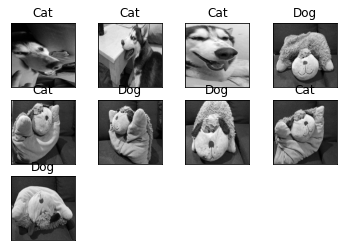

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure()

i=0
for img in os.listdir(test_dir):
    y = fig.add_subplot(3,4,i+1)
    
    path = os.path.join(test_dir,img)
    orig = np.array(cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size,img_size)))
    data = load_image(os.path.join(test_dir,img))
    
    model_out = model_trained.predict(data)
    
    if np.argmax(model_out) == 1:
        str_label = 'Dog'
    else: 
        str_label = 'Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    i+=1
plt.show()

In [22]:
# Hilariously ResNet50 performed worse (only for my specific test pictures) compared
# to my own CNN structure

In [24]:
# Let's see again ResNet50's model metrics
model_trained.evaluate(testing_set)

157/157 [==============================] - 58s 364ms/step - loss: 0.2322 - accuracy: 0.9418


[0.23224414885044098, 0.941788375377655]